#### Import Libraries

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys

#### Import Data (and select part of it only)

In [31]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def pick_class(x_train, y_train, class_n):
    new_x_train=x_train[y_train==class_n]
    new_y_train=y_train[y_train==class_n]
    print(len(new_y_train))
    return new_x_train, new_y_train

class_to_pick = 0
x_train, y_train = pick_class(x_train, y_train, class_to_pick)

#data_inputs = 1000
#x_train = x_train[0:data_inputs]
#y_train = y_train[0:data_inputs]

5923


#### Define Data Size and Classes

In [0]:
# INPUT DATA
class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1

N_train = len(y_train)
N_test = len(y_test)
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

#### Plot images from set (random or in order)

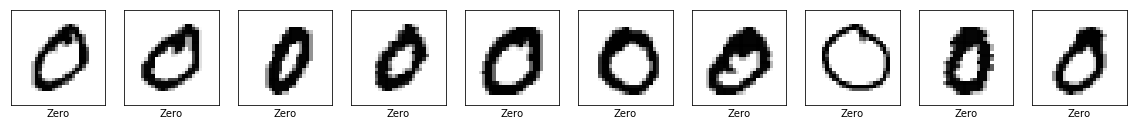

In [33]:
def plot_images(x_train, y_train, figures_to_plot=10, pick_random=True):
    n_rows = np.ceil(figures_to_plot/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        plt.xlabel(class_names[y_train[pic_n]])
    plt.show()

plot_images(x_train, y_train, 10, False)

#### Pre-Proces Data

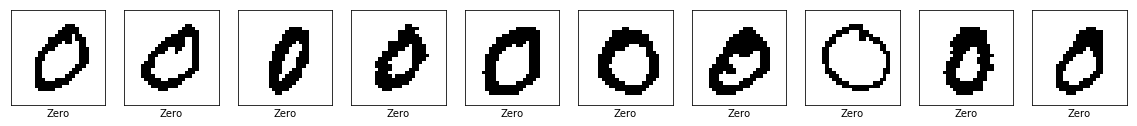

In [34]:
train_images = x_train/input_range
test_images = x_test/input_range

train_images[train_images >= 0.5] = 1.0
train_images[train_images < 0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images < 0.5] = 0.0

train_labels = y_train
test_labels = y_test

plot_images(train_images, train_labels, 10, False)

train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

#### Create Dataset

In [0]:
batch_size = 100
shuffle_size_train = 20000
shuffle_size_test = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(shuffle_size_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(shuffle_size_test).batch(batch_size)

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                          tf.keras.layers.Flatten(),
                          # No activation
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.InputLayer(input_shape=(z_size,)),
                          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
                          tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
                          # No activation
                          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
                          ])
    @tf.function
    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        eps = tf.random.normal(shape=z_mean.shape)
        return eps * tf.exp(z_logvar * 0.5) + z_mean
    
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

z_size = 50
model = CVAE(z_size)

#### Define the loss function 

In [0]:
@tf.function
def compute_loss(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_output = model.decode(z)
    #pixel_prob = tf.math.sigmoid(pixel_output)

    logpx_z_pixels = -tf.nn.sigmoid_cross_entropy_with_logits(logits=pixel_output, labels=x)
    #logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    logpz_z_parameters = -0.5 * (z ** 2.0 + np.log(2.0 * np.pi))
    logpz_z_vector = tf.reduce_sum(logpz_z_parameters, axis=1)
    logpz = tf.reduce_mean (logpz_z_vector)
    
    logqz_x_parameters = -0.5 * ((z - z_mean) ** 2.0 * tf.exp(-z_logvar) + z_logvar + np.log(2.0 * np.pi))
    logqz_x_vectors = tf.reduce_sum(logqz_x_parameters, axis=1)
    logqz_x = tf.reduce_mean (logqz_x_vectors)
    
    #kl_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2) - tf.exp(-z_logvar))
    #kl_vectors = tf.reduce_sum(kl_parameters, axis=1)
    #kl = tf.reduce_mean(kl_vectors)
    
    return -(logpx_z + logpz - logqz_x) #### why negative?? ####
    #return -(logpx_z + kl)

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4) #### why doesn't it work for 1e-3?? ####

#### Calculate the loss function gradients and input these to the optimizer

In [0]:
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
#### Generate random image from latent vector

In [0]:
z_random = tf.random.normal(shape=[16, z_size])

def generate_and_save_images(model, z_random): 
    generated_output = model.decode(z_random)
    generated_prob = tf.math.sigmoid(generated_output)
    fig = plt.figure(figsize=(4,4))

    for i in range(generated_prob.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_prob[i, :, :, 0], cmap=plt.cm.binary)
        plt.axis('off')
    plt.show()

#### Train the data

Epoch 1 progress (%): 100.0
Test set ELBO: 212.2196044921875; epoch running time: 0.7347099781036377


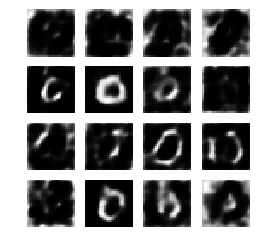

Epoch 2 progress (%): 100.0
Test set ELBO: 212.74952697753906; epoch running time: 0.6150789260864258


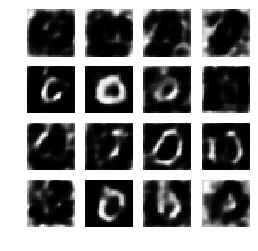

Epoch 3 progress (%): 100.0
Test set ELBO: 212.25120544433594; epoch running time: 0.6193912029266357


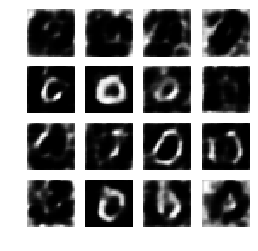

Epoch 4 progress (%): 100.0
Test set ELBO: 205.6815948486328; epoch running time: 0.6118202209472656


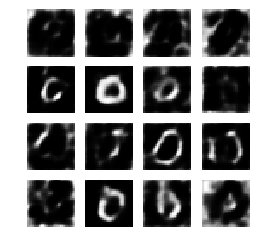

Epoch 5 progress (%): 100.0
Test set ELBO: 199.79714965820312; epoch running time: 0.6182229518890381


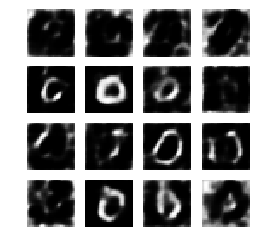

Epoch 6 progress (%): 100.0
Test set ELBO: 194.7381591796875; epoch running time: 0.6135799884796143


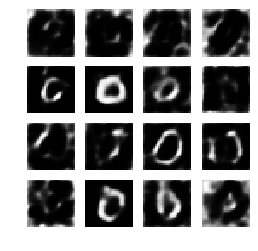

Epoch 7 progress (%): 100.0
Test set ELBO: 196.76730346679688; epoch running time: 0.6148378849029541


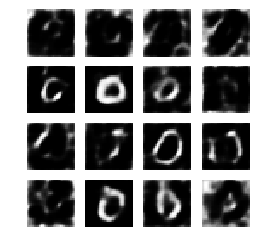

Epoch 8 progress (%): 100.0
Test set ELBO: 197.63063049316406; epoch running time: 0.616588830947876


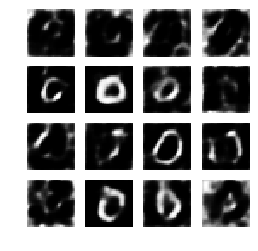

Epoch 9 progress (%): 100.0
Test set ELBO: 192.8739776611328; epoch running time: 0.6154189109802246


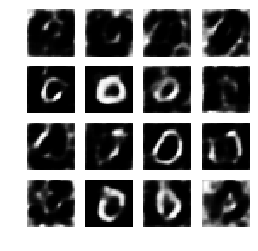

Epoch 10 progress (%): 100.0
Test set ELBO: 190.64402770996094; epoch running time: 0.613649845123291


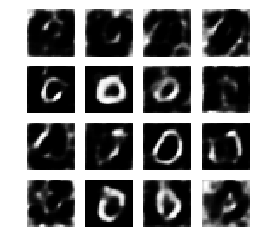

Epoch 11 progress (%): 100.0
Test set ELBO: 189.6577606201172; epoch running time: 0.6231069564819336


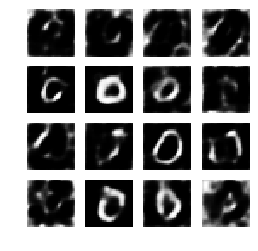

Epoch 12 progress (%): 100.0
Test set ELBO: 186.9157257080078; epoch running time: 0.611940860748291


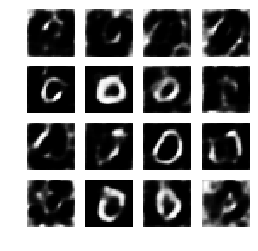

Epoch 13 progress (%): 100.0
Test set ELBO: 186.3957061767578; epoch running time: 0.6139655113220215


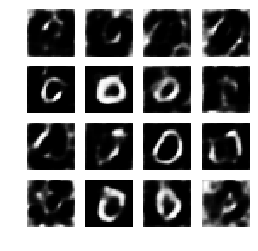

Epoch 14 progress (%): 100.0
Test set ELBO: 186.59498596191406; epoch running time: 0.6141488552093506


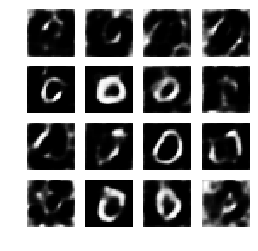

Epoch 15 progress (%): 100.0
Test set ELBO: 185.13900756835938; epoch running time: 0.6180040836334229


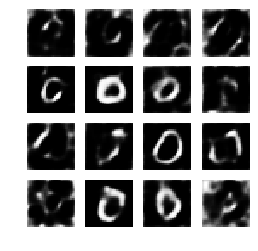

Epoch 16 progress (%): 100.0
Test set ELBO: 183.0144500732422; epoch running time: 0.6111428737640381


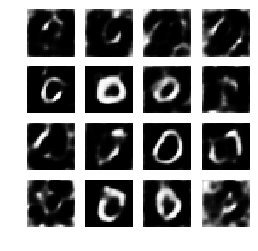

Epoch 17 progress (%): 100.0
Test set ELBO: 181.64918518066406; epoch running time: 0.6142573356628418


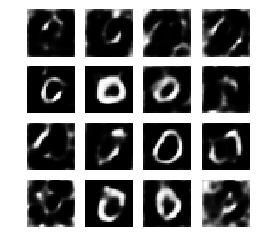

Epoch 18 progress (%): 100.0
Test set ELBO: 182.71670532226562; epoch running time: 0.614680290222168


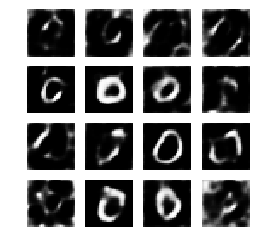

Epoch 19 progress (%): 100.0
Test set ELBO: 180.75367736816406; epoch running time: 0.6125431060791016


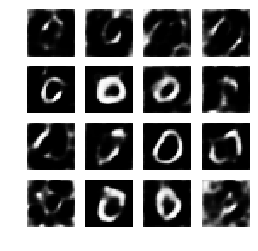

Epoch 20 progress (%): 100.0
Test set ELBO: 178.50193786621094; epoch running time: 0.6154913902282715


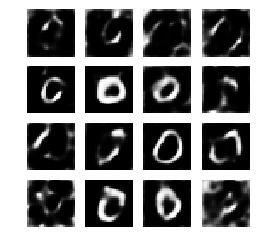

Epoch 21 progress (%): 100.0
Test set ELBO: 179.3433837890625; epoch running time: 0.6172308921813965


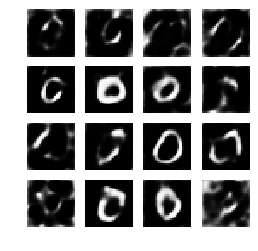

Epoch 22 progress (%): 100.0
Test set ELBO: 179.96217346191406; epoch running time: 0.6127326488494873


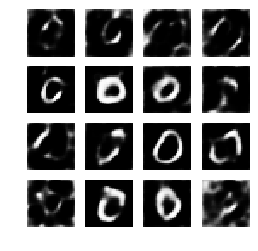

Epoch 23 progress (%): 100.0
Test set ELBO: 177.7289581298828; epoch running time: 0.6176886558532715


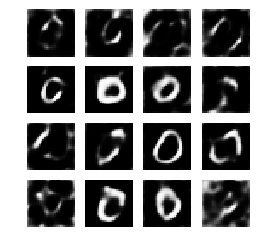

Epoch 24 progress (%): 100.0
Test set ELBO: 177.4939422607422; epoch running time: 0.6164553165435791


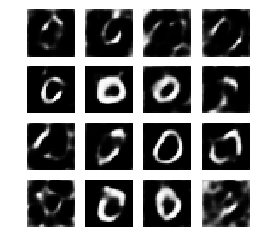

Epoch 25 progress (%): 100.0
Test set ELBO: 176.79013061523438; epoch running time: 0.6149756908416748


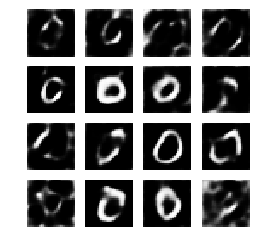

Epoch 26 progress (%): 100.0
Test set ELBO: 178.0247039794922; epoch running time: 0.6116576194763184


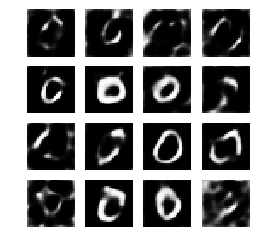

Epoch 27 progress (%): 100.0
Test set ELBO: 176.22030639648438; epoch running time: 0.6125791072845459


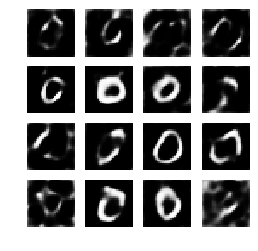

Epoch 28 progress (%): 100.0
Test set ELBO: 176.50440979003906; epoch running time: 0.6191327571868896


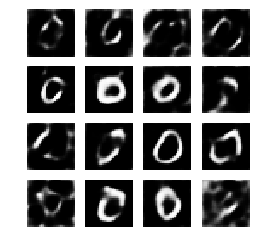

Epoch 29 progress (%): 100.0
Test set ELBO: 174.1746063232422; epoch running time: 0.6146678924560547


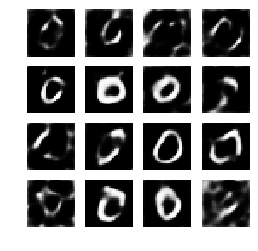

Epoch 30 progress (%): 100.0
Test set ELBO: 171.3832550048828; epoch running time: 0.6127383708953857


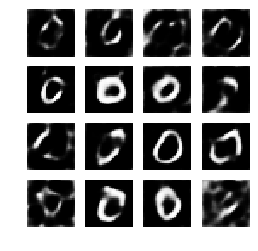

Epoch 31 progress (%): 100.0
Test set ELBO: 172.73193359375; epoch running time: 0.6156723499298096


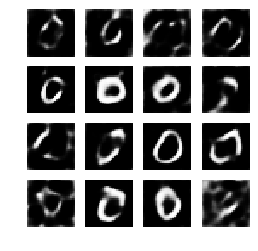

Epoch 32 progress (%): 100.0
Test set ELBO: 174.1580047607422; epoch running time: 0.6196856498718262


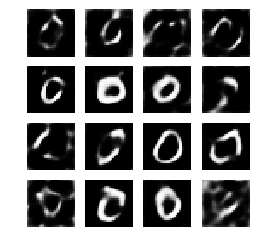

Epoch 33 progress (%): 100.0
Test set ELBO: 171.83724975585938; epoch running time: 0.6151034832000732


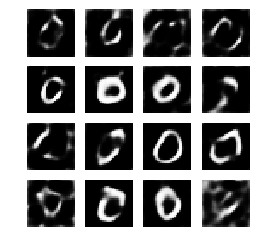

Epoch 34 progress (%): 100.0
Test set ELBO: 170.9727020263672; epoch running time: 0.615241289138794


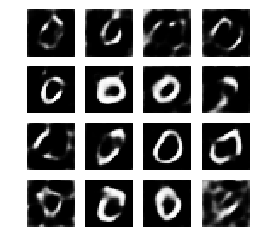

Epoch 35 progress (%): 100.0
Test set ELBO: 173.0820770263672; epoch running time: 0.6216115951538086


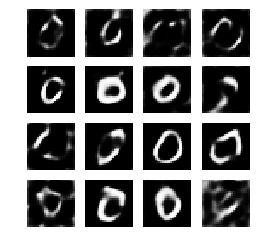

Epoch 36 progress (%): 100.0
Test set ELBO: 169.74072265625; epoch running time: 0.6168079376220703


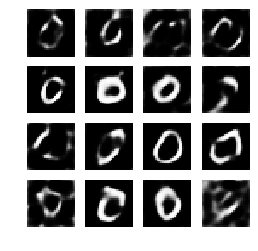

Epoch 37 progress (%): 100.0
Test set ELBO: 169.59820556640625; epoch running time: 0.6202821731567383


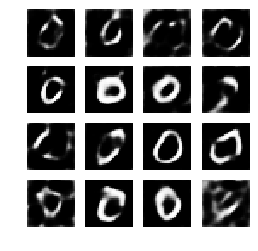

Epoch 38 progress (%): 100.0
Test set ELBO: 169.4635772705078; epoch running time: 0.6212029457092285


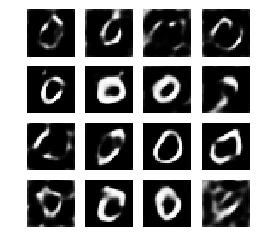

Epoch 39 progress (%): 100.0
Test set ELBO: 170.37867736816406; epoch running time: 0.6169729232788086


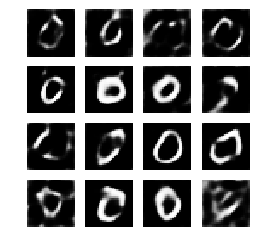

Epoch 40 progress (%): 100.0
Test set ELBO: 170.48056030273438; epoch running time: 0.6173455715179443


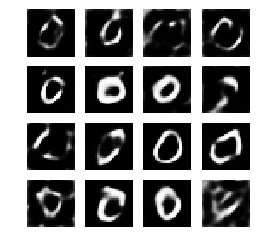

Epoch 41 progress (%): 100.0
Test set ELBO: 170.10496520996094; epoch running time: 0.6177115440368652


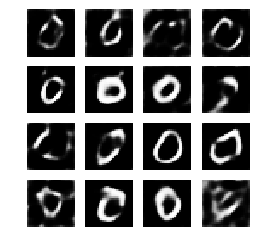

Epoch 42 progress (%): 100.0
Test set ELBO: 169.26211547851562; epoch running time: 0.6192138195037842


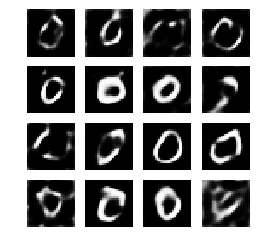

Epoch 43 progress (%): 100.0
Test set ELBO: 171.21005249023438; epoch running time: 0.6117424964904785


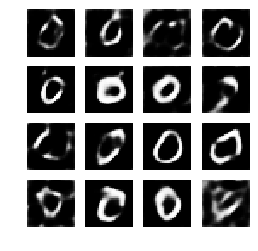

Epoch 44 progress (%): 100.0
Test set ELBO: 168.30650329589844; epoch running time: 0.6185088157653809


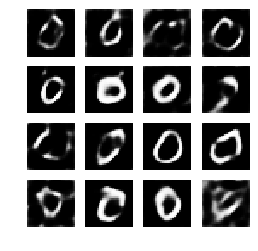

Epoch 45 progress (%): 100.0
Test set ELBO: 167.9192352294922; epoch running time: 0.6203618049621582


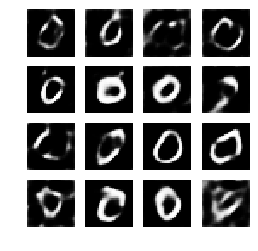

Epoch 46 progress (%): 100.0
Test set ELBO: 168.54368591308594; epoch running time: 0.6143696308135986


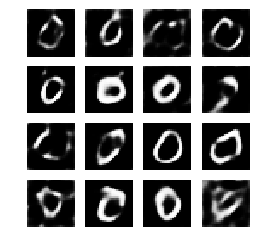

Epoch 47 progress (%): 100.0
Test set ELBO: 168.25750732421875; epoch running time: 0.6115798950195312


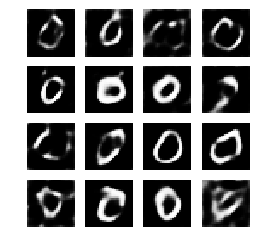

Epoch 48 progress (%): 100.0
Test set ELBO: 167.07371520996094; epoch running time: 0.614638090133667


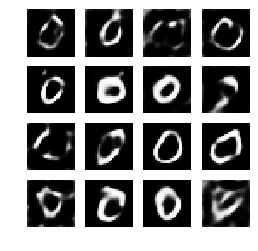

Epoch 49 progress (%): 100.0
Test set ELBO: 166.82135009765625; epoch running time: 0.6152682304382324


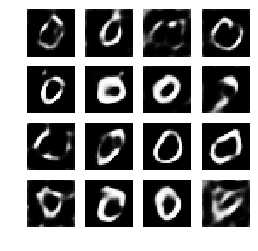

Epoch 50 progress (%): 100.0
Test set ELBO: 167.55401611328125; epoch running time: 0.612532377243042


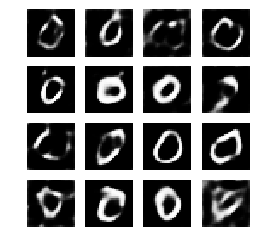

In [43]:
epochs = 50

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for i, train_x in enumerate(train_dataset): 
        sys.stdout.write('\r'+'Epoch {} progress (%): {}'.format(epoch,100*(i+1)/(np.ceil(N_train/batch_size))))
        sys.stdout.flush()
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    average_loss = 0
    for i, test_x in enumerate(test_dataset):
        batch_loss = compute_loss(model, test_x)
        average_loss = (average_loss*i + batch_loss)/(i+1)
    print('\nTest set ELBO: {}; epoch running time: {}'.format(average_loss, end_time - start_time))
    
    generate_and_save_images(model, z_random)

In [0]:
#### Reconstruct image

85.08969


<function matplotlib.pyplot.show>

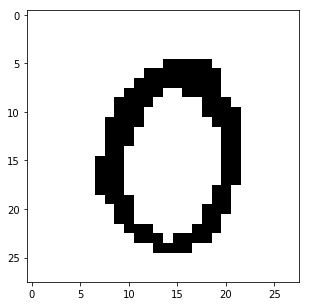

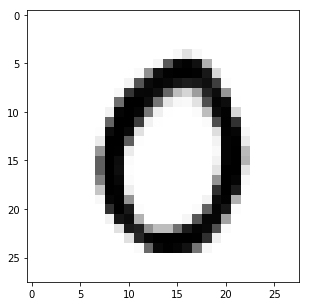

In [72]:
x = test_images[13:14]

z_mean, z_logvar = model.encode(x)
z = model.reparameterize(z_mean, z_logvar)
pixel_output = model.decode(z)
pixel_prob = tf.math.sigmoid(pixel_output)

loss = compute_loss(model,x)
print(loss.numpy())

fig = plt.figure(figsize=(5,5))
plt.imshow(x[0,:, :, 0], cmap=plt.cm.binary)
plt.show

fig = plt.figure(figsize=(5,5))
plt.imshow(pixel_prob[0,:, :, 0], cmap=plt.cm.binary)
plt.show